In [18]:
# Import the necessary libs for the homework
import torch
from torch import nn 
import matplotlib.pyplot as plt 
import numpy as np 
import math
import pandas as pd


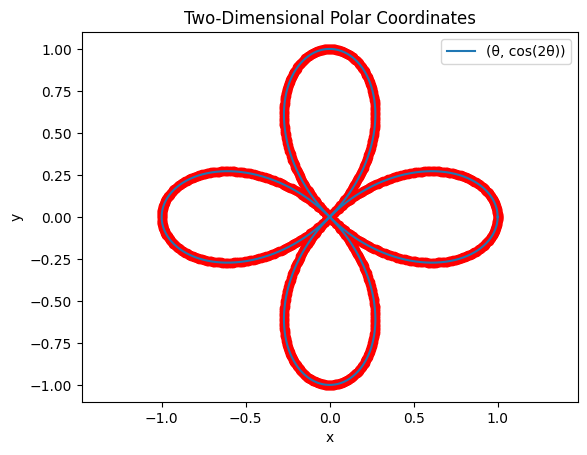

In [19]:
# Generate the initial dataset :
train_len = 1024
train_data = torch.zeros(train_len, 2)

# Generate polar coordinates
theta = torch.linspace(0, 2 * math.pi, train_len)  # 1000 points between 0 and 2π
r = torch.cos(2 * theta)

# Convert to Cartesian coordinates
x = r * torch.cos(theta)
y = r * torch.sin(theta)

train_data[:,0] = r * torch.cos(theta)
train_data[:,1] = r * torch.sin(theta)

# Plot the points
plt.plot(x, y, label='(θ, cos(2θ))')
plt.scatter(x, y, color='red')  # Scatter plot to highlight individual points
plt.title('Two-Dimensional Polar Coordinates')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()

# Format the initial data into a loader to make a more efficient code :
batch_size = 32                         # --------------------------------------------------------  Batch size 

# Wrap the tensor in a TensorDataset to assure compatibility in the code :
train_dataset = torch.utils.data.TensorDataset(train_data)

# Create a DataLoader using the dataset :
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [20]:
# Let's start with the generator as a simple neural network 
class Generator(nn.Module):

     def __init__(self):
         super().__init__()
         self.model = nn.Sequential(
             nn.Linear(2, 16), # Input is two dimensional
             nn.ReLU(),
             nn.Linear(16, 32),
             nn.ReLU(),
             nn.Linear(32, 64),
             nn.ReLU(),
             nn.Linear(64, 32),
             nn.ReLU(),
             nn.Linear(32, 2),  # Output is two dimensional
         )

     def forward(self, x):
         output = self.model(x)
         return output

# Build the discriminator as a NN
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256), #the input is two-dimensional
            nn.ReLU(),
            nn.Dropout(0.3), #droput layers reduce overfitting
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),#sigmoid activation to represent probability
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [21]:
# Sets the parameters
lr_d = 0.0002
lr_g = 0.0001
loss_function = nn.BCELoss()
num_epochs = 1000

Epoch: 0 Loss D.: 0.6924096345901489
Epoch: 0 Loss G.: 0.6988325119018555


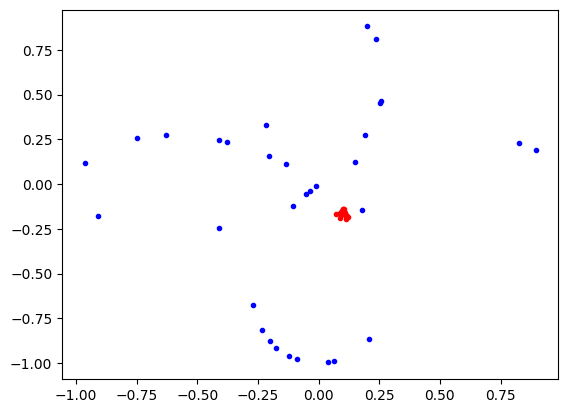

Epoch: 100 Loss D.: 0.6932916641235352
Epoch: 100 Loss G.: 0.7456215620040894


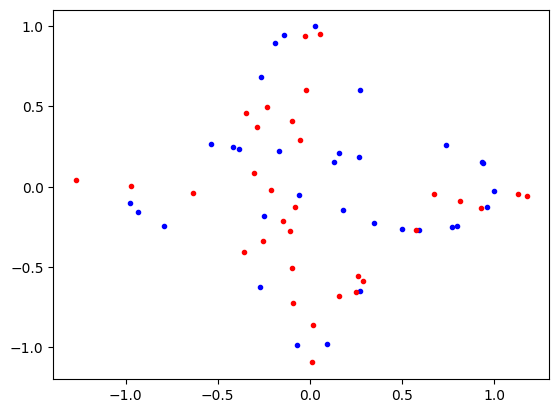

Epoch: 200 Loss D.: 0.6691861748695374
Epoch: 200 Loss G.: 0.715420663356781


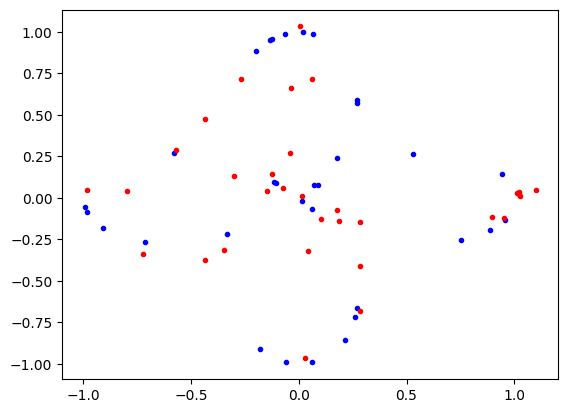

Epoch: 300 Loss D.: 0.6719015836715698
Epoch: 300 Loss G.: 0.8004117608070374


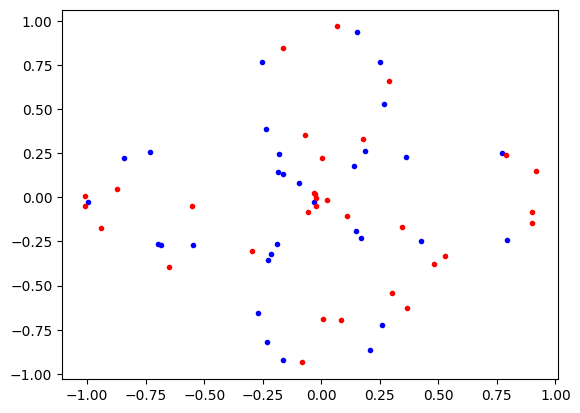

Epoch: 400 Loss D.: 0.6935731172561646
Epoch: 400 Loss G.: 0.6711515784263611


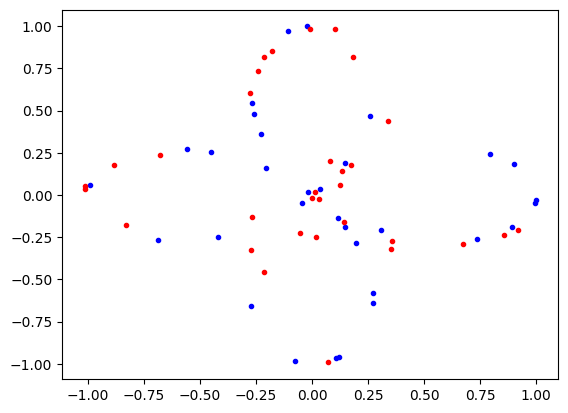

Epoch: 500 Loss D.: 0.6813367009162903
Epoch: 500 Loss G.: 0.7211208939552307


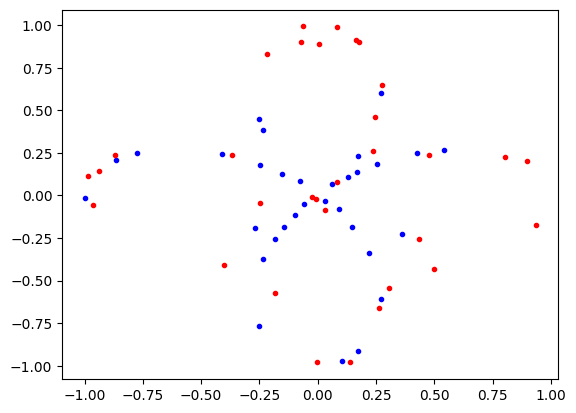

Epoch: 600 Loss D.: 0.6756351590156555
Epoch: 600 Loss G.: 0.7305735945701599


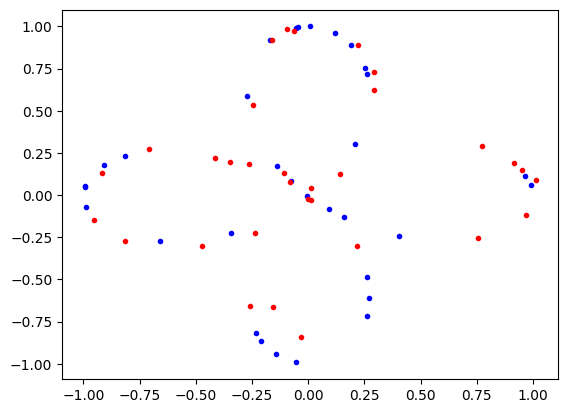

Epoch: 700 Loss D.: 0.6493787169456482
Epoch: 700 Loss G.: 0.6949295997619629


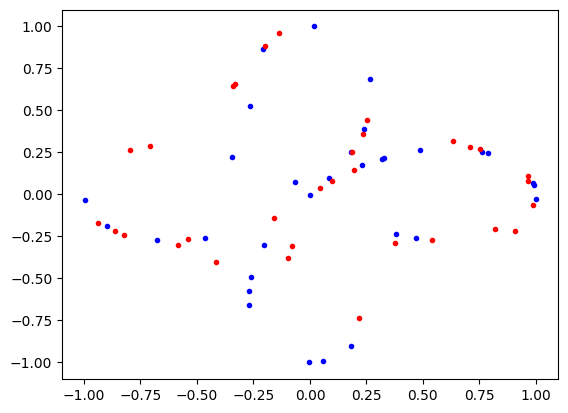

Epoch: 800 Loss D.: 0.6869680881500244
Epoch: 800 Loss G.: 0.6857068538665771


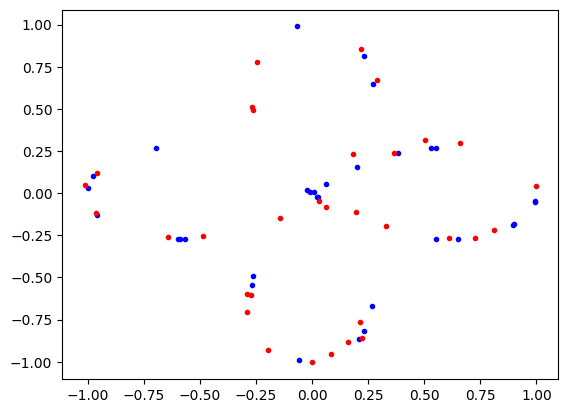

Epoch: 900 Loss D.: 0.6489929556846619
Epoch: 900 Loss G.: 0.7533922791481018


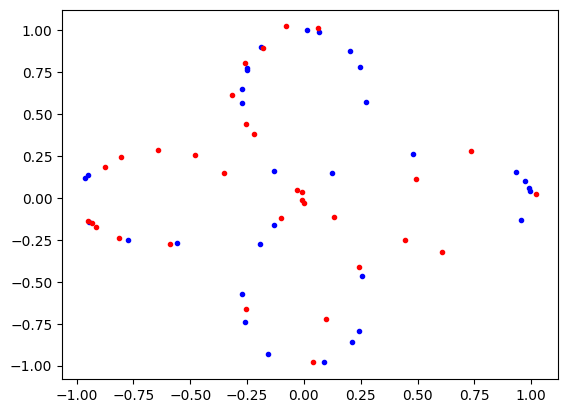

In [22]:
# Training loop :

discriminator = Discriminator()
generator = Generator()
gen_loss_vector = []
discr_loss_vector = []
num_epoch_vector = []


optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_d)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_g)

for epoch in range(num_epochs):
    for idx, real_data_set in enumerate(train_loader):
        real_data_set = real_data_set[0]
        # Preparing the real data to train the discriminator:
        real_data_label = torch.ones(batch_size,1)

        # Preparing the fake data to train the discriminator: 
        noise_data_set = torch.randn((batch_size, 2))
        fake_data_set = generator(noise_data_set)
        fake_data_label = torch.zeros(batch_size, 1)

        # Creating the training samples set:
        training_data_set = torch.cat((real_data_set, fake_data_set))

        # Creating the training labels set:
        training_labels_set = torch.cat((real_data_label, fake_data_label))

        # Train the discriminator:
        discriminator.zero_grad()
        output_discriminator = discriminator(training_data_set)
        loss_discriminator = loss_function(
            output_discriminator, training_labels_set)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Initialising the data for the discriminator: 
        noise_data_set = torch.randn((batch_size, 2))

        # Train the generatot: 
        generator.zero_grad()
        output_generator = generator(noise_data_set)
        
        # We use the discriminator output to back propagate:
        output_discriminator_generated  = discriminator(output_generator)
        loss_generator = loss_function(
            output_discriminator_generated, real_data_label) 
        # We put label = 1 so that the error we want to minimize is the distance between our generated data and the label 1

        loss_generator.backward()
        optimizer_generator.step()

        # prepares data for loss plot afterwise:
        if idx == 1:
            gen_loss_vector.append(float(loss_generator))
            discr_loss_vector.append(float(loss_discriminator))
            num_epoch_vector.append(epoch)

        # Show loss
        if epoch % 100 == 0 and idx == 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


            generated_samples_for_plotting = output_generator.detach()

            # Plot real samples in blue
            plt.plot(real_data_set[:, 0], real_data_set[:, 1], ".", color='blue')
            
            # Plot generated samples in red
            plt.plot(generated_samples_for_plotting[:, 0], generated_samples_for_plotting[:, 1], ".", color='red')
            
            plt.show()



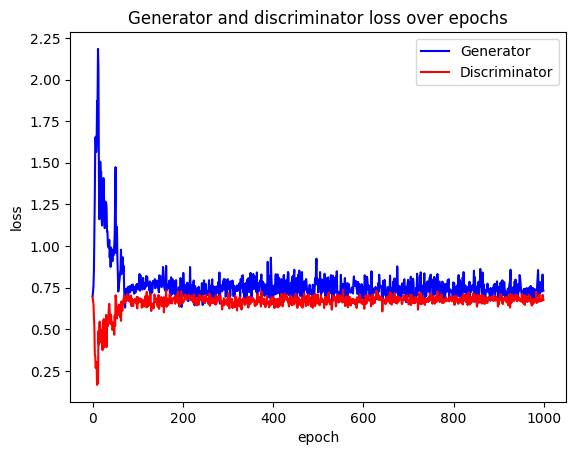

In [23]:
# Plot the functions on the same graph
plt.plot(num_epoch_vector, gen_loss_vector, label='Generator', color = 'b')  
plt.plot(num_epoch_vector, discr_loss_vector, label='Discriminator', color = 'r')  
plt.legend()  
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Generator and discriminator loss over epochs')
plt.show()